In [1]:
import struct
import pandas as pd
import os
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits

#### .dat to .csv / .txt converter

In [ ]:
def convert_dat_file(input_file_path, output_format='txt'):
    """ Convert a .dat file into a .txt, .csv, .fits, .hdf, or .hdf5 file."""

    # Read the binary file contents
    with open(input_file_path, "rb") as f:
        data = f.read()

    # Convert binary data into list of 32-bit floats (little endian)
    floats = list(struct.iter_unpack('<f', data))
    flat_floats = [val[0] for val in floats]

    # Create DataFrame
    df = pd.DataFrame(flat_floats, columns=['Value'])

    # Determine output file path
    base_name = os.path.splitext(input_file_path)[0]
    output_format = output_format.lower()

    if output_format == 'csv':
        output_file = f"{base_name}_converted.csv"
        df.to_csv(output_file, index=False)

    elif output_format == 'txt':
        output_file = f"{base_name}_converted.txt"
        df.to_csv(output_file, index=False, sep='\t')

    elif output_format == 'fits':
        output_file = f"{base_name}_converted.fits"
        hdu = fits.PrimaryHDU(df['Value'].values)
        hdu.writeto(output_file, overwrite=True)

    elif output_format in ['hdf', 'hdf5']:
        output_file = f"{base_name}_converted.{output_format}"
        df.to_hdf(output_file, key='data', mode='w')

    else:
        raise ValueError("Unsupported output format. Choose 'csv', 'txt', 'fits', 'hdf', or 'hdf5'.")

    print(f"File saved as {output_file}")
    return output_file

# Usage
converted_path = convert_dat_file("observation.dat", output_format='txt')

File saved as observation_converted.csv


##### Check file contents

In [11]:
with open("observation.dat", "rb") as f:
    raw = f.read(256)

print(raw[:256])


b'5\x90\x9c=\x81\xb5\x9a=\x182\x99=\xf7g\x9c=cc\x9a=\xbc\x80\x9c=\x1a\x96\x9a=\x0bb\x9f=\x04\x05\xa6=\x08N\xa1=K\x8e\x9a=\xef\xf4\x96=}e\x99=\xf1\x15\x9c=\xb7\xdd\x9d=;\xdc\x9e=\xa4\x85\x9a=\x95%\x8e=\x83\x8b\x8b=\xa5\xfb\x93=\x1e\\\x9c=\xcb\xc8\x9d=\x88\xf4\x97=@]\x97=\xf1\x01\x98=1\x8c\x9a=\x98\xa7\x9f=\xc3\xcf\x9a=\xf6\x01\x9a=\x8fY\x9b=Gc\x8e=N$\x88=\x83\xc9\x93=\x85\xed\xa1=\x1b\xb8\xa8=\xcc\xde\x9e=\x88\x10\x98=\xb3$\x97=\xa3\x03\x95=}d\x97=\xb0\xdd\x99=\x85\x8b\x9e=\xeaL\x99=g \x90=9\x9a\x94=\x00}\x91=:\xb1\x8e=<M\x91="\xda\x95=\xb2a\x90=\x85\x14\x92=c\xfe\x91=\xf1\xa9\x8f=)\xdf\x92=\x00b\x98=\x881\x9a=\xf79\x9d=?\xd2\x9d=\xc98\x9c=@R\x9a=\xc6\xaa\x92=R\xd5\x90=&\x07\x8d=\x8a\x9a\x8b='


#### Plot txt / csv file points in waterfall graph

Estimated points_per_second: 1024


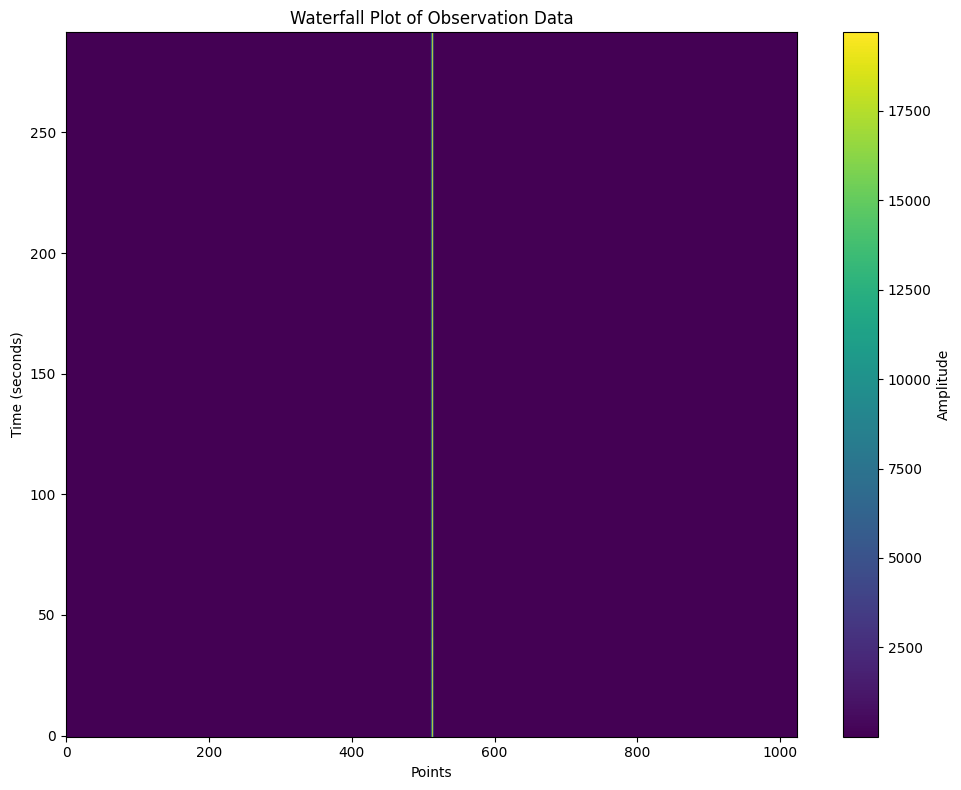

In [ ]:
def guess_points_per_second(data, min_duration=60, max_duration=600):
    """Try to find a plausible points_per_second by checking GCDs over expected durations"""
    total_points = len(data)
    candidates = []

    for duration in range(min_duration, max_duration + 1):
        if total_points % duration == 0:
            points = total_points // duration
            candidates.append(points)

    if not candidates:
        raise ValueError("Couldn't find a valid points_per_second automatically.")

    # Choose the one closest to 1000
    return min(candidates, key=lambda x: abs(x - 1000))

def plot_waterfall(file_path):
    # Load data
    if file_path.endswith('.txt'):
        df = pd.read_csv(file_path, sep='\t')
    elif file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    else:
        raise ValueError("Unsupported file format. Only .txt and .csv are allowed.")
    
    data = df['Value'].values

    # Auto-detect points_per_second
    points_per_second = guess_points_per_second(data)
    print(f"Estimated points per second: {points_per_second}")

    # Truncate data to full seconds
    total_seconds = len(data) // points_per_second
    data = data[:total_seconds * points_per_second]

    # Reshape into 2D array (each row is 1 second)
    reshaped = data.reshape((total_seconds, points_per_second))

    # Plot
    plt.figure(figsize=(10, 8))
    plt.imshow(reshaped, aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='Amplitude')
    plt.xlabel('Points')
    plt.ylabel('Time (seconds)')
    plt.title('Waterfall Plot of Observation Data')
    plt.tight_layout()
    plt.show()

# Plot waterfall
plot_waterfall(converted_path)